# Project 1: Counting words in college subreddits

Due 9/16. Reminder that you are allowed to use any amount of AI assistance or outside resources with citation

## Part 1: word counting and bag of words

In [1]:
#install spacy in the current conda environment
!pip install spacy
!pip install matplotlib
!pip install --upgrade numpy gensim


  Using cached numpy-2.0.2-cp39-cp39-macosx_14_0_x86_64.whl.metadata (60 kB)


In [2]:
#download a small language model to help with cleaning tasks
!python -m spacy download en_core_web_sm



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 1.2 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [3]:
#import required libraries
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import spacy
language_model = spacy.load("en_core_web_sm")
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import gensim
import gensim.corpora as corpora
from gensim.models import LdaModel
from collections import Counter

### Problem 1 and example: common words in the Michigan subreddit

In [4]:
#read the data from a csv file in the folder
mich=pd.read_csv("umich.csv")

In [5]:
#jupyter will print a pretty representation of most python objects if you just put the name
#we can see that the full text of each reddit comment is provided in the "text" column
mich

,Unnamed: 0,date,post_votes,text,user,com_votes
0,0,2024-09-04 15:33:20,2,"Zingermans has a nice reuben, pretty pricey bu...",Suspicious-Bad703,2
1,1,2024-09-04 15:33:20,2,I really love Tomokun!,webstbre000,2
2,2,2024-09-04 15:33:20,2,The Seoul is pretty good I especially like the...,iaxlmao,1
3,3,2024-09-04 15:33:20,2,A lot of it depends on what type of food and w...,I-696,1
4,4,2024-09-04 14:32:17,1,You can book completely enclosed private study...,sneep_,2
...,...,...,...,...,...,...
8334,8334,2024-07-02 12:35:36,9,It isn’t a student org,Vibes_And_Smiles,1
8335,8335,2024-07-02 11:07:10,0,Life \nMatter \nLife's matter,tctu,8
8336,8336,2024-07-02 11:07:10,0,google,SUPERazkari,4
8337,8337,2024-07-02 11:07:10,0,That’s a hard question to answer for a set of ...,Own-Resident-3837,-1


In [6]:
#this is a function that does some light cleaning, by removing newline characters, converting to lowercase, and removing punctuation

def clean(text):
    #remove newline and space characters
    text = ' '.join(text.split())
    #convert the text to lowercase
    text = text.lower()
    #remove punctuation
    text = ''.join([char for char in text if char.isalpha() or char.isspace()])
    return text

In [7]:
#pandas allows us to quickly apply this cleaning function to all rows in a column
mich['cleaned_text'] = mich['text'].apply(clean)

In [8]:
#we can see the first comment after cleaning vs before
mich["cleaned_text"][0]

'zingermans has a nice reuben pretty pricey but the sammies are pretty big'

In [9]:
mich["text"][0]

'Zingermans has a nice reuben, pretty pricey but the sammies are pretty big'

In [10]:
#create a bag of words representation with count vectorizer
vectorizer = CountVectorizer()
bag_of_words = vectorizer.fit_transform(mich['cleaned_text'])

In [11]:
#this is a sparse matrix, which is a more efficient way to store a matrix with many zeros
#the matrix has 8339 rows (one for each comment) and 15289 columns (one for each unique word in the dataset)
bag_of_words

<8339x15289 sparse matrix of type '<class 'numpy.int64'>'
	with 221217 stored elements in Compressed Sparse Row format>

In [12]:
#create a dataframe from the sparse matrix
#this is a more human-readable way to view the data
bow_df = pd.DataFrame(bag_of_words.toarray(), columns=vectorizer.get_feature_names_out())
bow_df

,aa,aadl,aapd,aata,ab,abab,abandon,abandoned,abbreviation,abbreviations,...,zoned,zones,zoning,zoo,zoom,zoomer,zoomers,zuckerberg,𝓲𝓷𝓼𝓮𝓬𝓾𝓻𝓮,𝘢𝘩𝘦𝘮
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8334,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8335,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8336,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8337,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
#dataframes have a convenient method for summing the values in each column
#this will give us the number of times each word appears in the dataset
word_counts = bow_df.sum()
#we can sort the values to see the most common words
word_counts = word_counts.sort_values(ascending=False)

#notice that the top words are not very informative, as they are common words that appear in many contexts
#and bottom words include a lot of typos and other noise
word_counts

the            11306
to              8480
and             6921
you             6256
of              5028
               ...  
journals           1
journeywhen        1
jpg                1
js                 1
𝘢𝘩𝘦𝘮               1
Length: 15289, dtype: int64

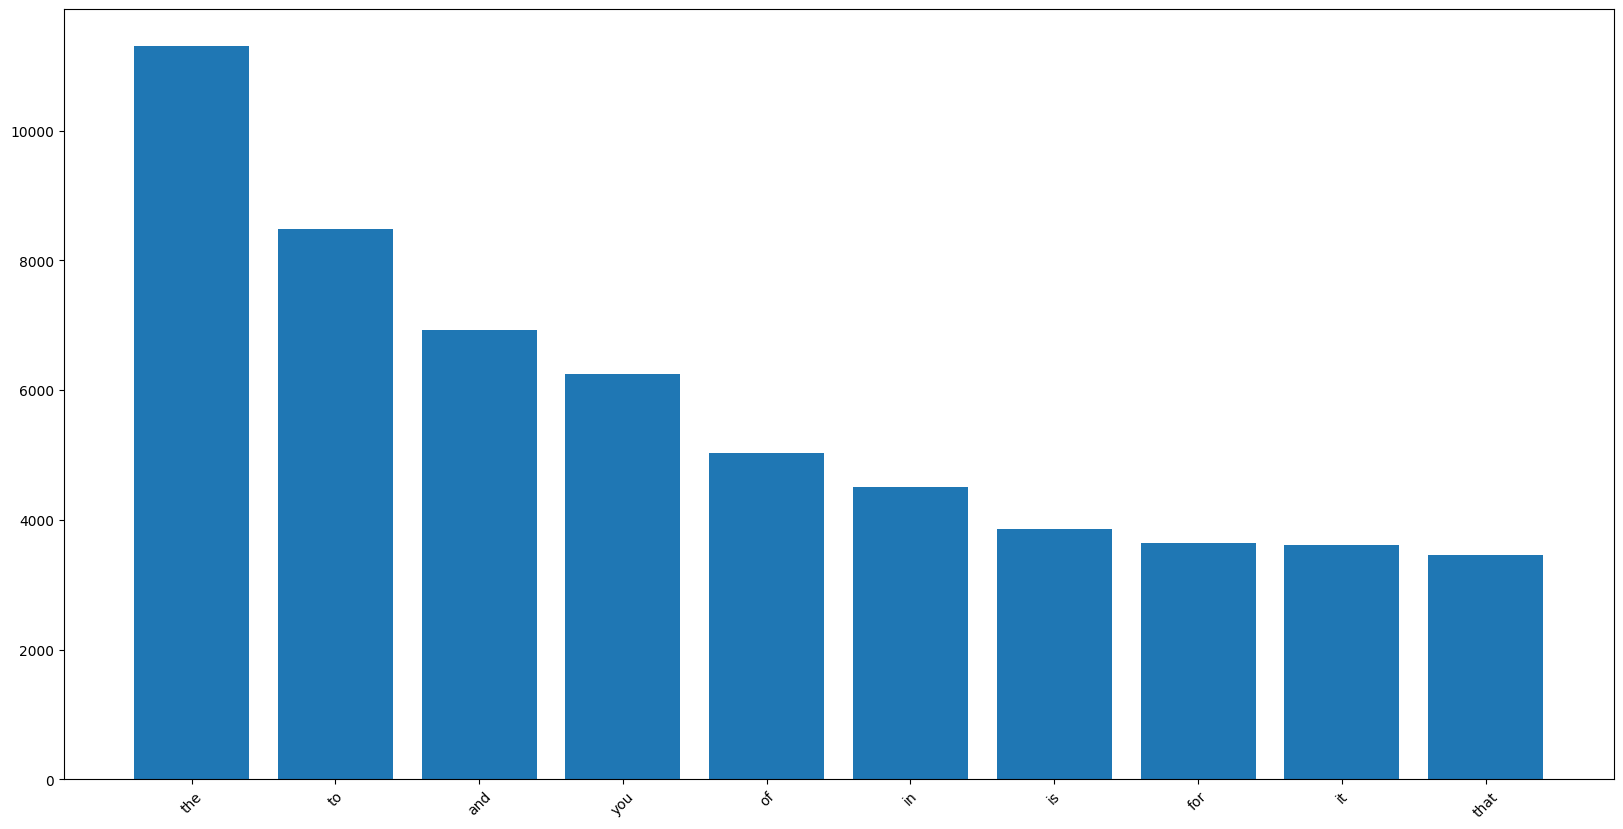

In [14]:
#we can plot the most common words
#we will only plot the top 10 words for readability
word_counts = word_counts.head(10)
plt.figure(figsize=(20,10))
plt.bar(word_counts.index, word_counts.values)
plt.xticks(rotation=45)
plt.show()

#### Question 1: what do you notice about the words in this plot? Is this useful for studying the community?

Answer here: These are all examples of common words said in almost every sentence. These words are neutral and have no emotion when read through text. These words are not useful for studying the community because they provide no useful information has to what messages are most importanly conveyed.  

#### Lemmatization and stopword removal

In [15]:
#lemmatization function from the openclassrooms reading
def lemmatize(text):

   doc = language_model(text)

   tokens = [token.lemma_ for token in doc if not (token.is_stop or token.is_punct)]

   return ' '.join(tokens)

In [16]:
#we can further process the text by removing stopwords and lemmatizing
mich['lemmatized_text'] = mich['cleaned_text'].apply(lemmatize)

In [17]:
#count vectorizer also has parameters min_df and max_df that can be used to filter out words that are too rare or too common
#min_df=3 means that a word must appear in at least 3 documents to be included, this will remove typos and rare words
#max_df=0.3 means that a word must appear in at most 30% of documents to be included, this will remove corpus-specific stopwords

#we are also able to include n-grams in the count vectorizer
#n-grams are sequences of n words that appear together in the text
#the n-gram_range parameter specifies the minimum and maximum n-gram size to include (so in this case, we are including both unigrams and bigrams)

vectorizer = CountVectorizer(min_df=3, max_df=0.3, ngram_range=(1,2))
bag_of_words = vectorizer.fit_transform(mich['lemmatized_text'])

In [18]:
#we can see that we filtered out 11000 common words and typos
bag_of_words

<8339x8608 sparse matrix of type '<class 'numpy.int64'>'
	with 126768 stored elements in Compressed Sparse Row format>

In [19]:
#we can repeat the previous code to create a dataframe and count the words
bow_df = pd.DataFrame(bag_of_words.toarray(), columns=vectorizer.get_feature_names_out())
word_counts = bow_df.sum()
word_counts = word_counts.sort_values(ascending=False)
word_counts

not              2863
student          1183
like             1183
people           1124
class             988
                 ... 
club campus         3
open not            3
open source         3
club activity       3
luck search         3
Length: 8608, dtype: int64

In [20]:
#we can convert this to a percentage instead of an absolute count by dividing by the total number of words
word_counts = word_counts / word_counts.sum()

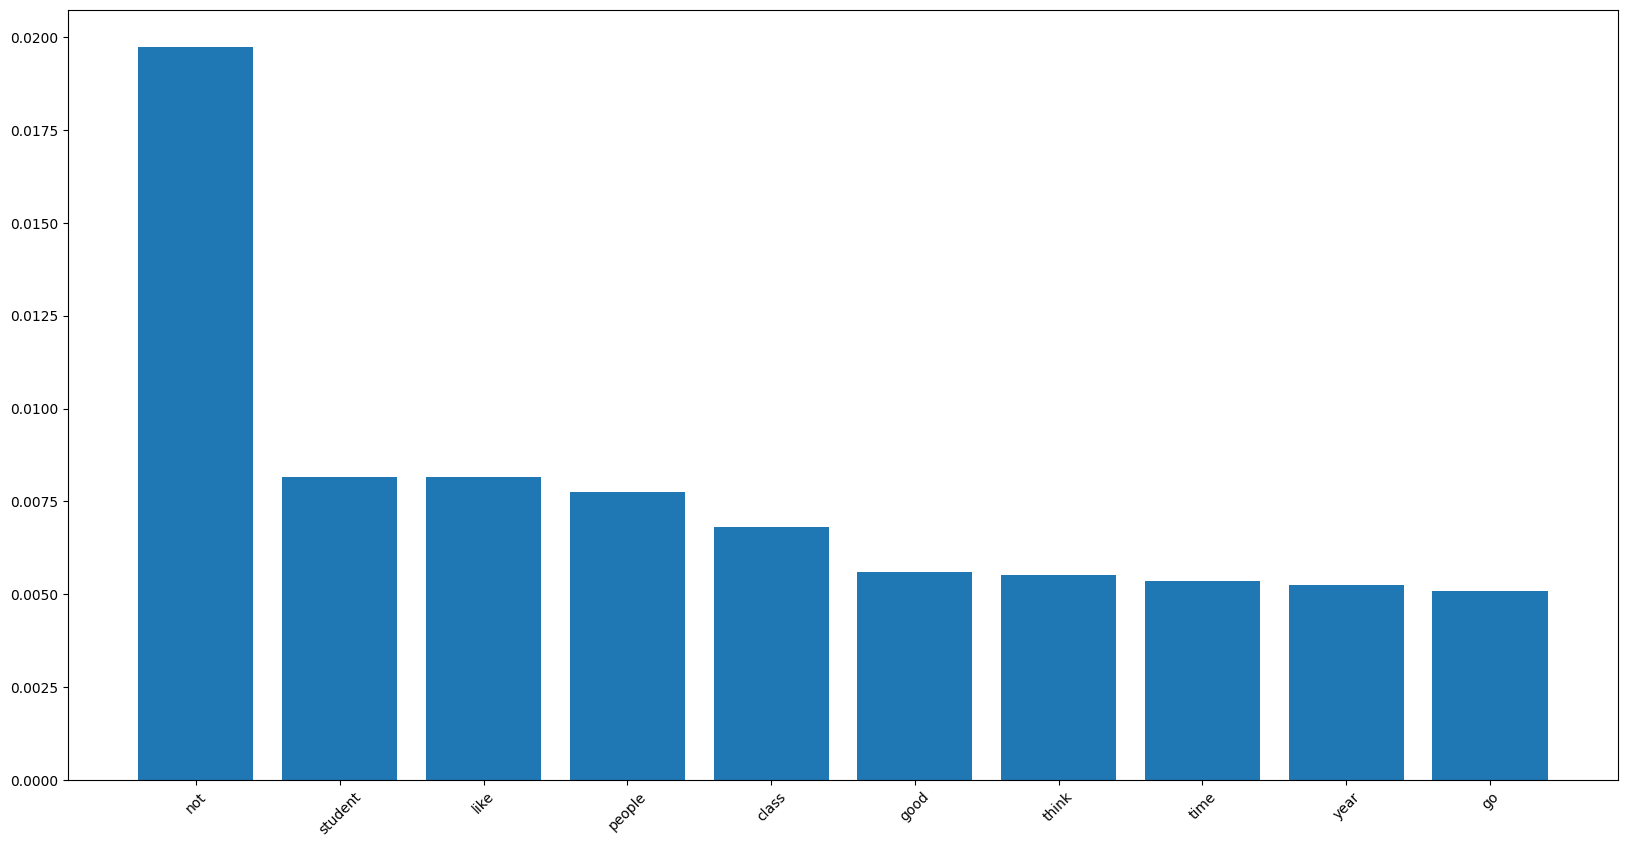

In [21]:
#we can plot the most common words
#we will only plot the top 10 words for readability
plot_list = word_counts.head(10)
plt.figure(figsize=(20,10))
plt.bar(plot_list.index, plot_list.values)
plt.xticks(rotation=45)
plt.show()

In [22]:
#pandas allows us to access specific words in the series using the index
word_counts["student loan"]

4.1400153180566765e-05

In [23]:
#we can also use a list of words to compare and plot specific words
plot_list=word_counts[["history", "business", "computer science", "cs", "computer"]]
plot_list

history             0.000352
business            0.000600
computer science    0.000035
cs                  0.001228
computer            0.000262
dtype: float64

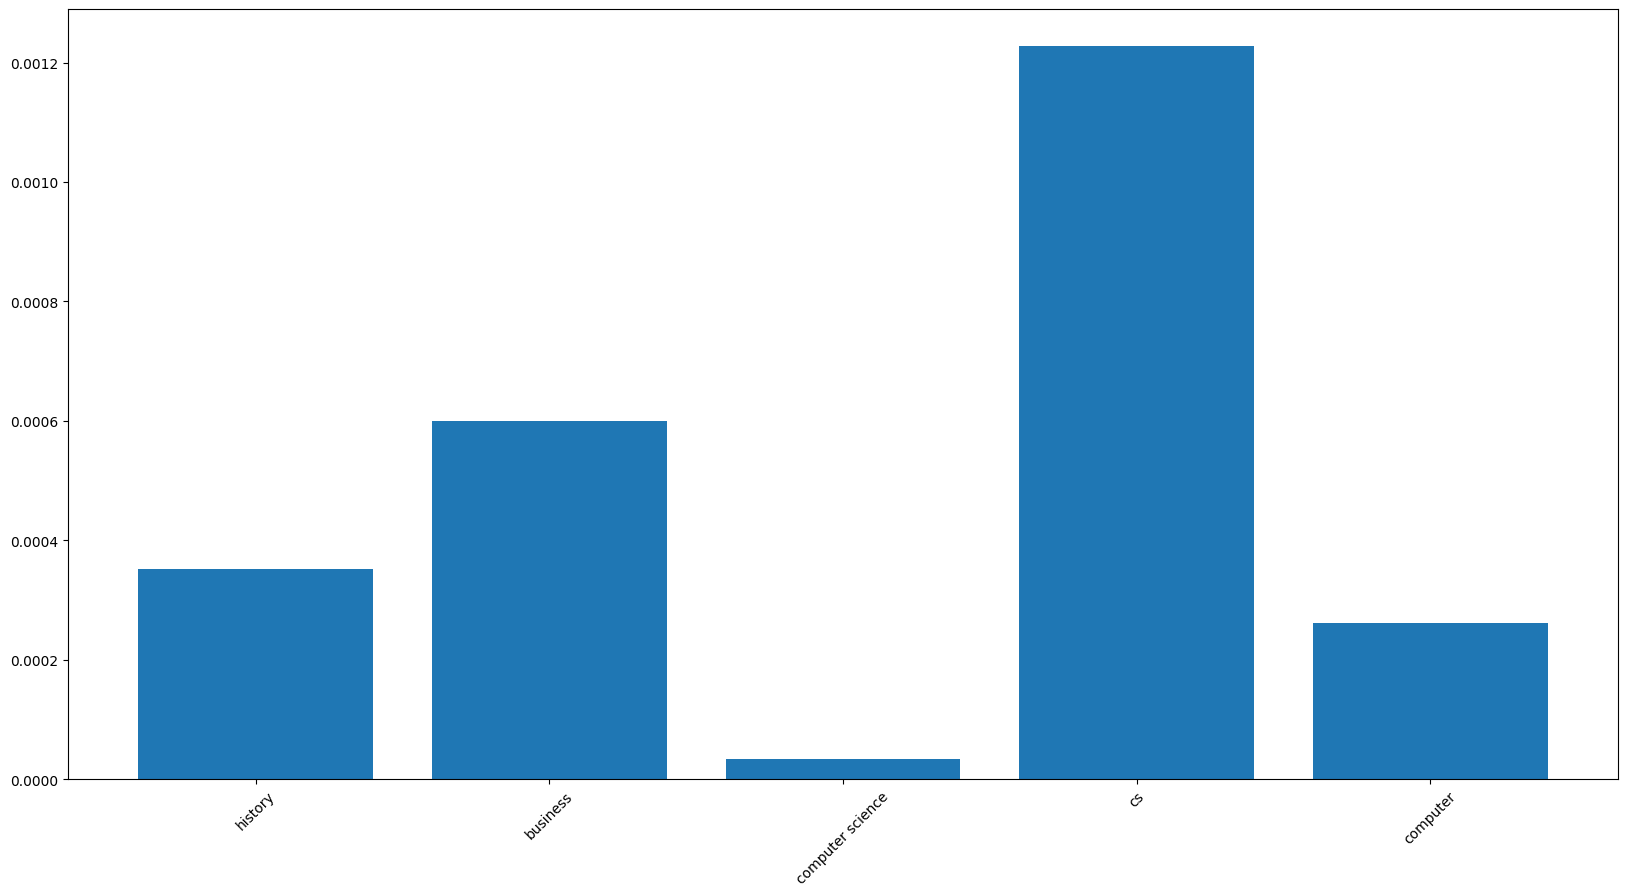

In [24]:

plt.figure(figsize=(20,10))
plt.bar(plot_list.index, plot_list.values)
plt.xticks(rotation=45)
plt.show()

#### Question 2:

In [25]:
#TODO: pick 5 words that you find interesting or are curious about, and plot a bar plot of their frequency in this dataset 

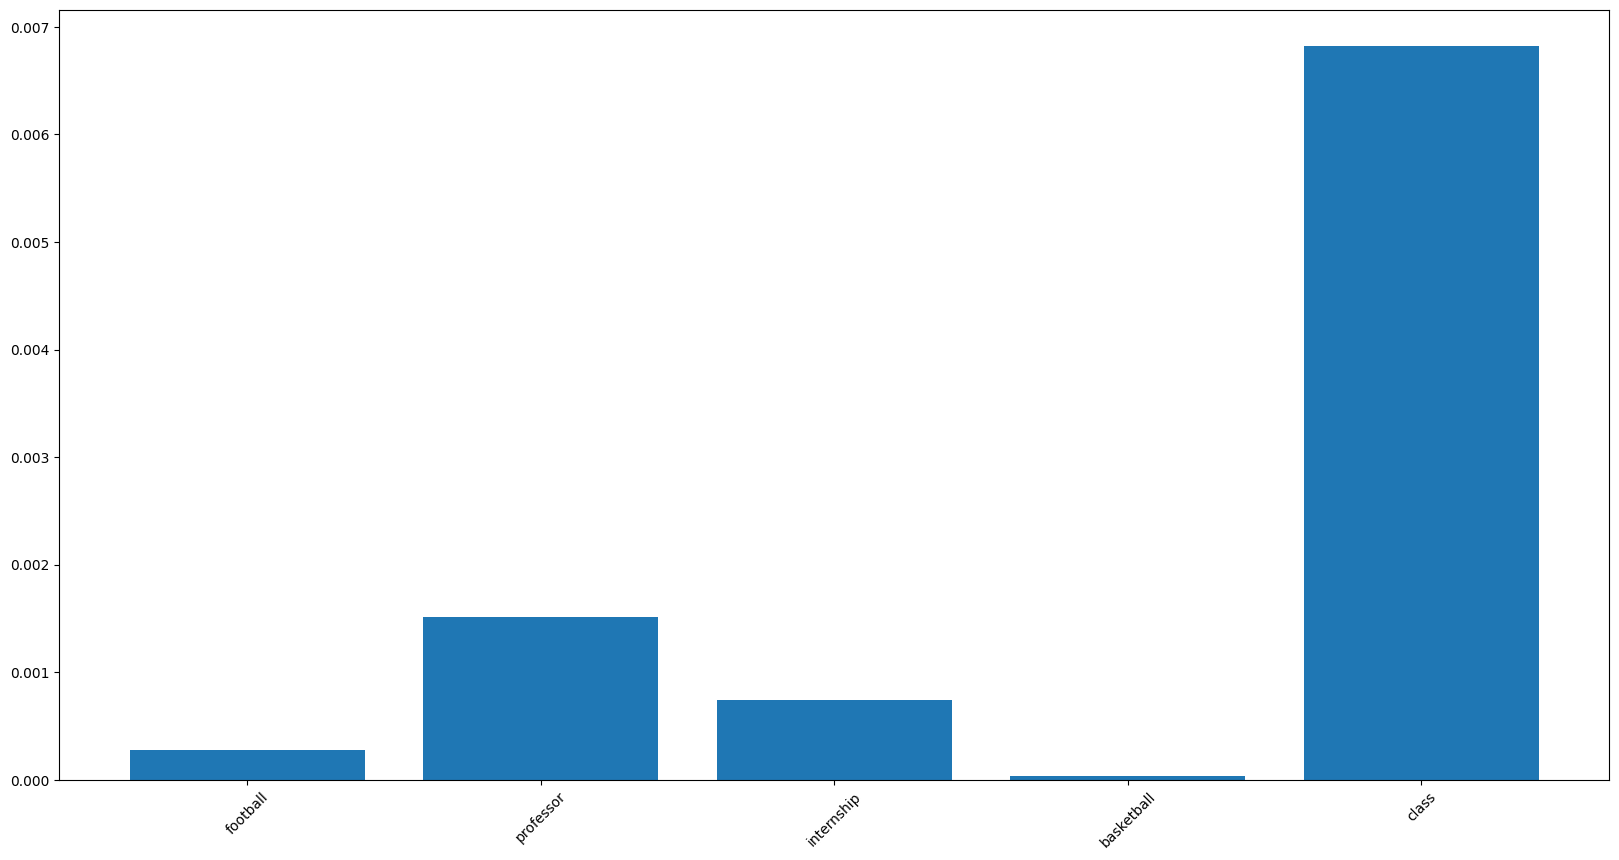

In [26]:
plot_2=word_counts[["football", "professor", "internship", "basketball", "class"]]
plt.figure(figsize=(20,10))
plt.bar(plot_2.index, plot_2.values)
plt.xticks(rotation=45)
plt.show()

### Problem 2: repeat this process with the Illinois subreddit data (in this directory as "uiuc.csv"). You should not have to change too much in the previous code besides the dataframe path and name. Your notebook should include the two bar graphs including and excluding stopwords. Use the same 5 words and compare their relative frequency between the two subreddits. Discuss any interesting differences you notice in a short markdown cell. 

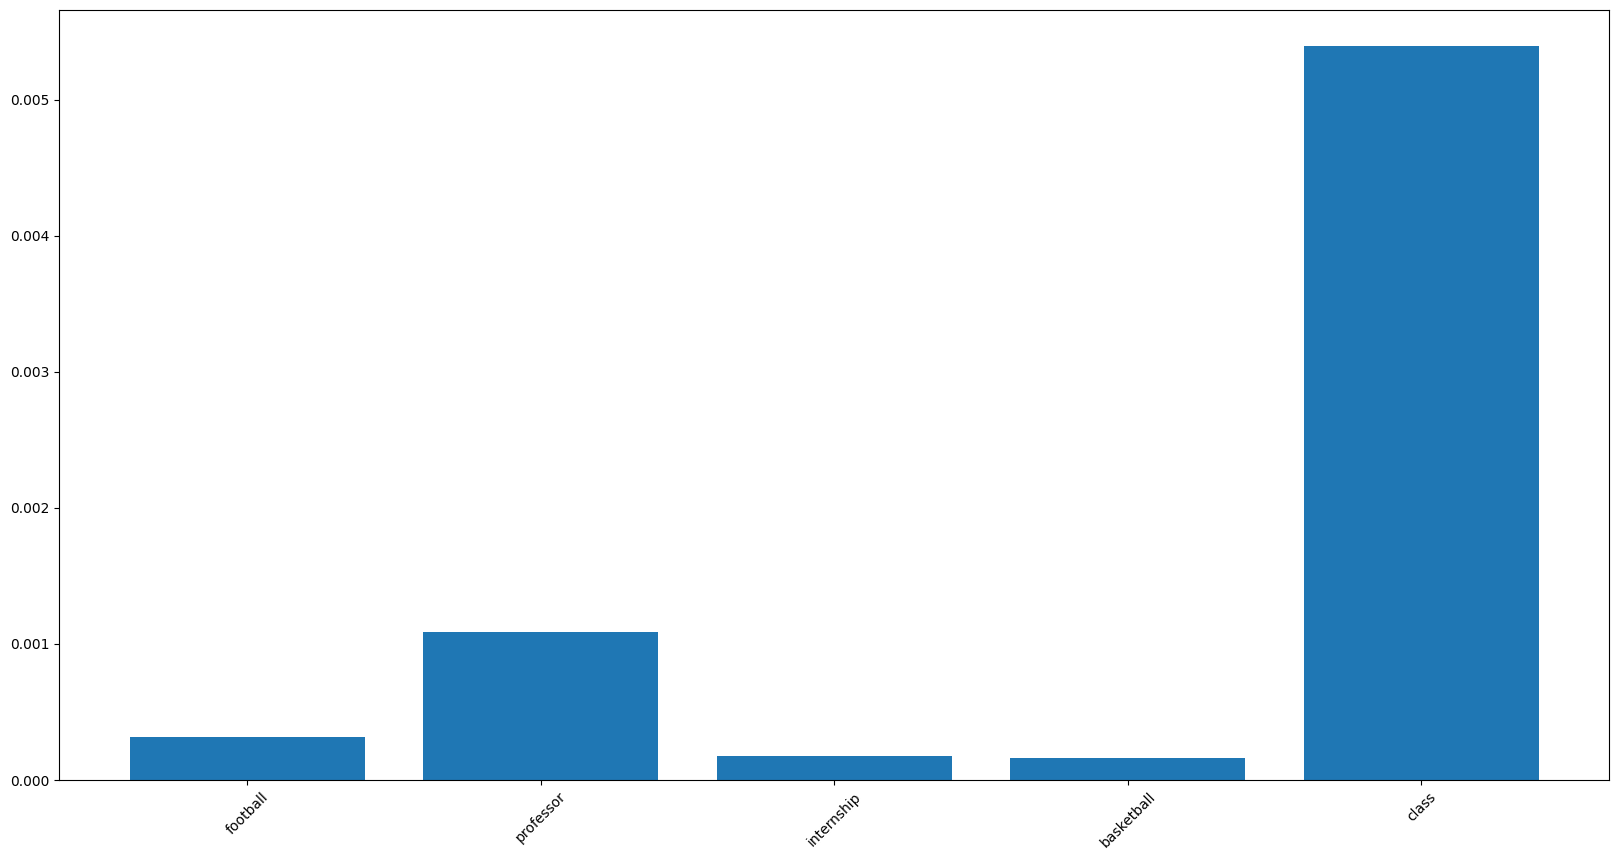

In [27]:
uiuc=pd.read_csv("uiuc.csv")
def lemmatize(text):

   doc = language_model(text)

   tokens = [token.lemma_ for token in doc if not (token.is_stop or token.is_punct)]

   return ' '.join(tokens)
uiuc['lemmatized_text'] = uiuc['text'].apply(lemmatize)
vectorizer = CountVectorizer(min_df=3, max_df=0.3, ngram_range=(1,2))
bag_of_words = vectorizer.fit_transform(uiuc['lemmatized_text'])
bow_df = pd.DataFrame(bag_of_words.toarray(), columns=vectorizer.get_feature_names_out())
word_counts = bow_df.sum()
word_counts = word_counts.sort_values(ascending=False)
word_counts = word_counts / word_counts.sum()
plot_3=word_counts[["football", "professor", "internship", "basketball", "class"]]
plt.figure(figsize=(20,10))
plt.bar(plot_3.index, plot_3.values)
plt.xticks(rotation=45)
plt.show()

### Problem 3: using the provided combined dataframe, train a logistic regression model using the sklearn Logistic Regression implementation. https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html. Create a bag of words table from the combined data, and use that along with the "label" column to train the classifier. Please try this out and be prepared with issues or questions next Monday. We will be discussing in class

In [28]:
uiuc=pd.read_csv("uiuc.csv")
mich=pd.read_csv("umich.csv")

#sample so we have even number of samples from each dataset
mich=mich.sample(n=4725)

#assign labels based on origin subreddit of comment
uiuc['label']=1
mich['label']=0

#you will be working with the data csv for the rest of the question
data=pd.concat([uiuc,mich])

In [29]:
#clean and lemmatize the data csv
def lemmatize(text):

   doc = language_model(text)

   tokens = [token.lemma_ for token in doc if not (token.is_stop or token.is_punct)]

   return ' '.join(tokens)
data['lemmatized_text'] = data['text'].apply(lemmatize)

In [30]:
#create a bag of words representation with count vectorizer
vectorizer = CountVectorizer(min_df=3, max_df=0.3, ngram_range=(1,2))
bag_of_words = vectorizer.fit_transform(data['lemmatized_text'])

In [31]:
#train a logistic regression model using the bag of words features as X and the label column as y
x = bag_of_words
y = data['label']
model = LogisticRegression()
model.fit(x, y)
y_pred = model.predict(x)
accuracy = accuracy_score(y, y_pred)

In [32]:
#report the accuracy of the model
print("Accuracy:", accuracy)

Accuracy: 0.9059259259259259


#### Part 2: hold out part of the dataset using sklearn train_test_split (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html). Pass in your previously generated bag of words as X and the label column as y. Use only the X_train and y_train for training and hold out the X_test and y_test to score the model on unseen data.

In [33]:
# what is the accuracy of the model? Is it better or worse than previous?Why do you think it has changed? 

The accuracy is worse than previous. This is because the first time, the score is sort of artifical as the model has alreay seen this data before. Also the model with a lower accuracy score test on unseen data, which causes it to be lower

In [34]:
vectorizer = CountVectorizer(min_df=3, max_df=0.3, ngram_range=(1,2))
bag_of_words = vectorizer.fit_transform(data['lemmatized_text'])
x = bag_of_words
y = data['label']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Model accuracy on test set: {accuracy:.4f}")

Model accuracy on test set: 0.7190


#### Part 3: Examine the top features of your model using the following code

In [35]:
#get the coefficients of the model and plot the top 10 most positive and top 10 most negative coefficients
#what do you notice about these words? Are they surprising or expected?


I noticed that the words talking about the actual school are the most positive, for example like: UIUC, RSO, and Grainger. Also, talking about the two cities, Urbana and Champagin, have mostly positive features as well. Meanwhile, the most negative words have to do with Michigan, like "Michigan" and "UMich", whihc is funny because it's like the opposite of UIUC.

In [36]:
feature_names = vectorizer.get_feature_names_out()
coefficients = pd.DataFrame({'feature': feature_names, 'coefficient': model.coef_[0]})
coefficients = coefficients.sort_values('coefficient', ascending=False)
top_10_positive = coefficients.head(10)
top_10_negative = coefficients.tail(10)


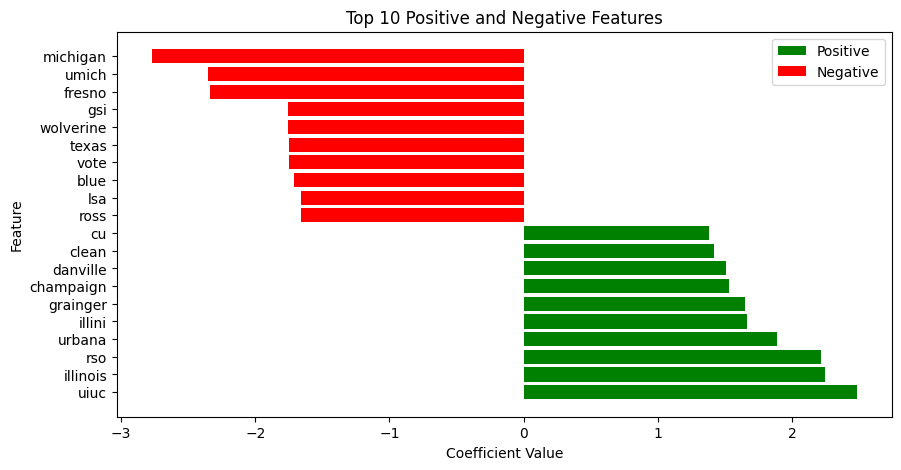

In [37]:
plt.figure(figsize=(10, 5))
plt.barh(top_10_positive['feature'], top_10_positive['coefficient'], color='green', label='Positive')
plt.barh(top_10_negative['feature'], top_10_negative['coefficient'], color='red', label='Negative')
plt.xlabel("Coefficient Value")
plt.ylabel("Feature")
plt.title("Top 10 Positive and Negative Features")
plt.legend()
plt.show()

In [38]:
#examine these words and see if they make sense. Do they differentiate UIUC from another university?

These words do differetiate from univeristy. It looks like the UIUC words have more positive features compared to Michigan's words

### Problem 4: Train a 10 topic topic model from the UIUC subreddit data using Gensim LDA. (https://radimrehurek.com/gensim/auto_examples/tutorials/run_lda.html) If you get here before Wednesday 9/11, don't rush to finish, but feel free to continue ahead. We will go through this in class. Print out the top words in each topic, and read through the words for each topic to decide the theme of the topic: remember this is subjective and there are no right or wrong answers. Print out a few comments with high frequencies of each topic and analyze if your topic labels were representative. 

In [39]:
uiuc = pd.read_csv("uiuc.csv")
uiuc["clean_text"] = uiuc["text"].apply(clean)

In [40]:
nlp = spacy.load("en_core_web_sm")

def tokenize(text):
    doc = nlp(text)
    return [token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
uiuc["tokens"] = uiuc["clean_text"].apply(tokenize)

In [41]:
id2word = corpora.Dictionary(uiuc["tokens"])
corpus = [id2word.doc2bow(text) for text in uiuc["tokens"]]

In [42]:
lda_model = LdaModel(
    corpus=corpus,
    id2word=id2word,
    num_topics=10,
    random_state=42,
    passes=10, 
    per_word_topics=True
)

In [43]:
for i, topic in lda_model.show_topics(formatted=False):
    print(f"Topic {i}: ", [word for word, prob in topic])

Topic 0:  ['not', 'right', 'student', 'year', 'come', 'anxiety', 'group', 'bedroom', 'hope', 'leave']
Topic 1:  ['thank', 'check', 'get', 'clean', 'charge', 'send', 'pipe', 'bus', 'county', 'champaign']
Topic 2:  ['class', 'not', 'like', 'freshman', 'year', 'lose', 'take', 'stay', 'great', 'walk']
Topic 3:  ['s', 'hall', 'm', 'cs', 'class', 'not', 'stop', 'dining', 'lol', 'graduate']
Topic 4:  ['not', 'apartment', 'bike', 'car', 'company', 'tow', 'move', 'charge', 'park', 'building']
Topic 5:  ['review', 'joke', 'play', 'head', 'go', 'fakespot', 'message', 'discount', 'game', 'sell']
Topic 6:  ['not', 'student', 'm', 'u', 'campus', 'university', 'uiuc', 'need', 'want', 'good']
Topic 7:  ['housing', 'student', 'not', 'get', 'oh', 'yeah', 'consider', 'see', 'house', 'walk']
Topic 8:  ['not', 'people', 'friend', 'm', 'like', 'time', 'feel', 's', 'know', 'find']
Topic 9:  ['water', 'not', 'good', 'ask', 'pay', 'year', 'use', 'know', 'get', 'thing']


I can orgainze the topics like this: Topic 0: Housing & Student Well-being  
Topic 1: Transportation & Campus Facilities  
Topic 2: Freshman Year & Academics  
Topic 3: Computer Science & Dining  
Topic 4: Off-Campus Housing & Transportation  
Topic 5: Entertainment & Reviews  
Topic 6: General Campus Discussions  
Topic 7: Housing & Rent  
Topic 8: Social Life & Friendships  
Topic 9: Tuition & Utility Costs  

In [44]:
topic_comments = {}

for i, row in enumerate(corpus):
    topic_dist = lda_model.get_document_topics(row)
    dominant_topic = sorted(topic_dist, key=lambda x: x[1], reverse=True)[0][0]

    if dominant_topic not in topic_comments:
        topic_comments[dominant_topic] = []
    
    topic_comments[dominant_topic].append(uiuc["text"].iloc[i])

for topic, comments in topic_comments.items():
    print(f"\nTopic {topic} Examples:\n")
    for comment in comments[:3]:
        print(comment)
        print("----")


Topic 8 Examples:

Have the same professor! And in lecture he did say we were gonna have to learn some of the stuff ourself 

I would recommend using online resources such as Paul’s Online Math Notes and Professor Leonard on YouTube. Personally, I’ve been learning the material from those sources before going to lecture
----
what are the activities in the club
----
Mass mail when the weather is slightly warm and they need you to conserve energy
----

Topic 6 Examples:

Do you find it helpful to still go to the lecture? It seems to me that his slides are embedded with mistakes here and there. It makes it more confusing for me to understand him.
----
I used to have the same problem. You just have to make sure that you installed the configuration on your device. If that wouldn't work, register it.
----
i dont think there is any cheap used one left
----

Topic 0 Examples:

Have you tried emailing University Housing to request access?
----
bookstor
----
😂🤣😂
----

Topic 3 Examples:

Purchasi

The topic model successfully identified structured discussions such as housing, dining, transportation, and financial concerns, with well-classified topics that closely aligned with their corresponding sample comments. General campus discussions were also accurately categorized, capturing student experiences and academic concerns effectively. However, some topics contained misclassified or mixed content. The social life and friendships topic included many academic-related discussions, making the label somewhat misleading. The freshman year and academics topic lacked clear relevance, as its comments were random and unrelated. Off-campus housing and transportation included discussions that had nothing to do with housing or transportation, suggesting that the model struggled to distinguish between broader campus-related conversations.

Entertainment and reviews contained some relevant content but also included low-quality, off-topic comments. Similarly, the housing and rent category featured discussions about student employment rather than rent-related issues. The model performed best when handling structured topics like housing, dining, and transportation, but it struggled with more general discussions and social interactions, leading to some overlap and misclassification. While many topics were well-defined, some lacked clear boundaries, causing inconsistencies in topic assignments.